In [11]:
from evo.tools import plot
from evo.tools import  file_interface
from evo.core import sync
from evo.core import metrics
import evo.main_ape as main_ape
import evo.common_ape_rpe as common
import pprint
from evo.tools import log
import os
log.configure_logging(verbose=True, debug=True, silent=False)

import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline


# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

dataset = "Euroc"
scene="MH_04_difficult"
# dataset="MH_03_medium"
loop_closure=False
# output_exp_data="./exp_data/results_"+dataset+str(datetime.now().strftime('%Y-%m-%d-%H:%M:%S'))+".txt"
base_path = "/home/nnplvio_ws/src/nn-pl-vio/Trajactory"
resfile_name = "evo_no_loop_1701658217519.txt"
resfile_path = os.path.join(dataset+"_"+scene, resfile_name)
gtfile_path = os.path.join("TrajVINS", scene, "data.csv")
# if loop_closure:
#     with open(gtfile_path,"r") as raw_result_file ,open(resfile_path,'w') as output_file:
#         for line in  raw_result_file:
#             data=line.split(",")
#             time_stamp=float(data[0])/1e9
#             output_file.write(" ".join([str(time_stamp)]+data[1:-1])+'\n')
# else:
#     with open(gtfile_path,"r") as raw_result_file ,open(resfile_path,'w') as output_file:
#         for line in  raw_result_file:
#             data=line.split(",")
#             time_stamp=float(data[0])/1e9
#             output_file.write(" ".join([str(time_stamp)]+data[1:-4])+'\n')
traj_ref = file_interface.read_euroc_csv_trajectory(gtfile_path)
traj_est = file_interface.read_tum_trajectory_file(resfile_path)

print(traj_ref)
print(traj_est)
traj_ref_0=traj_ref
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)

[DEBUG][2023-07-25 16:07:28,811][log.configure_logging():112]
System info:
Python 3.8.10
Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.17
plus@LAPTOP-Q466SVFQ

[DEBUG][2023-07-25 16:07:28,969][file_interface.read_euroc_csv_trajectory():209]
Loaded 19753 stamps and poses from: TrajVINS/MH_04_difficult/data.csv
[DEBUG][2023-07-25 16:07:28,983][file_interface.read_tum_trajectory_file():117]
Loaded 1995 stamps and poses from: Euroc_MH_04_difficult/frame_trajectory.txt
19753 poses, 91.747m path length, 98.760s duration
1995 poses, 961.978m path length, 101.600s duration
[DEBUG][2023-07-25 16:07:29,027][sync.associate_trajectories():110]
Found 1971 of max. 1995 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.01 (s) and time offset: 0.0 (s).


In [12]:
import copy

traj_est_aligned = copy.deepcopy(traj_est)
traj_est_aligned.align(traj_ref, correct_scale=True, correct_only_scale=False)

[DEBUG][2023-07-25 16:07:43,088][trajectory.align():202]
Aligning using Umeyama's method... (with scale correction)
[DEBUG][2023-07-25 16:07:43,095][trajectory.align():214]
Rotation of alignment:
[[-0.83467404  0.39395846 -0.38485839]
 [ 0.54365397  0.70114147 -0.46134695]
 [ 0.08808865 -0.59430411 -0.79940166]]
Translation of alignment:
[6.07075718 0.74928498 1.54855498]
[DEBUG][2023-07-25 16:07:43,096][trajectory.align():216]
Scale correction: 0.8760648150005238


(array([[-0.83467404,  0.39395846, -0.38485839],
        [ 0.54365397,  0.70114147, -0.46134695],
        [ 0.08808865, -0.59430411, -0.79940166]]),
 array([6.07075718, 0.74928498, 1.54855498]),
 0.8760648150005238)

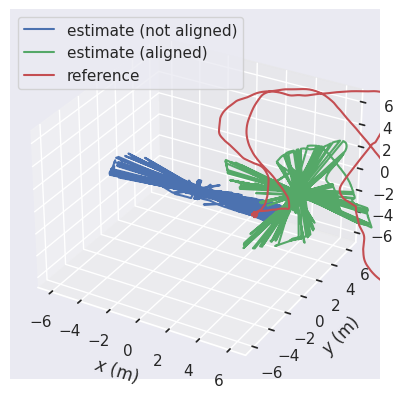

In [13]:
fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_est,
    "estimate (aligned)": traj_est_aligned,
    "reference": traj_ref,
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

In [8]:
pose_relation = metrics.PoseRelation.translation_part
use_aligned_trajectories = True

if use_aligned_trajectories:
    data = (traj_ref, traj_est_aligned) 
else:
    data = (traj_ref, traj_est)

ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)
print(ape_stat)
ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)

[DEBUG][2023-07-25 16:06:10,356][metrics.process_data():392]
Compared 189 absolute pose pairs.
[DEBUG][2023-07-25 16:06:10,357][metrics.process_data():393]
Calculating APE for translation part pose relation...
0.8513460923783734
{'max': 1.690959339876361,
 'mean': 0.7382801349089794,
 'median': 0.6357616495016635,
 'min': 0.1339177122621731,
 'rmse': 0.8513460923783734,
 'sse': 136.985341942498,
 'std': 0.4239488311184557}


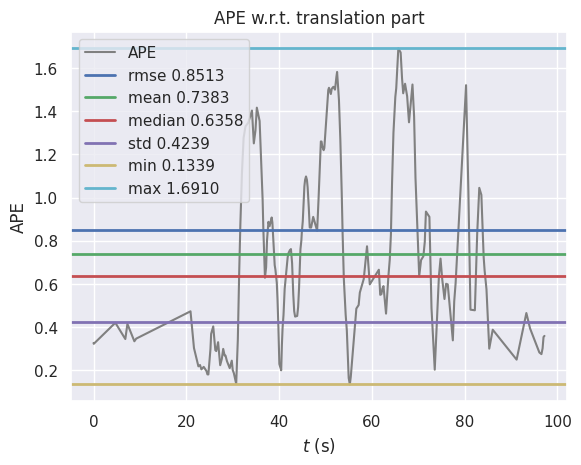

In [9]:
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]
fig = plt.figure()

plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                 statistics={s+f" {v:.4f}":v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

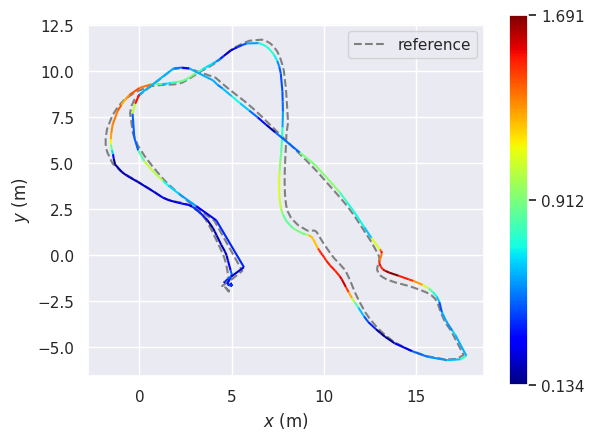

In [10]:
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_aligned if use_aligned_trajectories else traj_est, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()